In [1]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
%matplotlib inline

from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import joblib

In [8]:
# !pip install wordcloud
# !pip install termcolor

In [10]:
sns.set_style('white')
plt.rcParams['figure.figsize'] = (14.0, 8.7)

In [11]:
pyLDAvis.enable_notebook()


In [12]:
DATA_DIR = Path('data')
data_path = DATA_DIR / 'bbc'

In [13]:
results_path = Path('results')
model_path = Path('results', 'bbc')
if not model_path.exists():
    model_path.mkdir(exist_ok=True, parents=True)

In [14]:
files = sorted(list(data_path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

In [15]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()
train_docs, test_docs = train_test_split(docs,
                                         stratify=docs.topic,
                                         test_size=125,
                                         random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   article  2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [16]:
train_docs.shape, test_docs.shape

((2100, 3), (125, 3))

In [17]:
pd.Series(test_docs.topic).value_counts()

Sport            29
Business         29
Politics         23
Tech             22
Entertainment    22
Name: topic, dtype: int64

In [18]:
# experiments with different settings results yields the following hyperparameters (see issue 50)
vectorizer = TfidfVectorizer(max_df=.11, 
                             min_df=.026, 
                             stop_words='english')

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
test_dtm = vectorizer.transform(test_docs.article)
train_dtm,test_dtm

(<2100x1097 sparse matrix of type '<class 'numpy.float64'>'
 	with 113356 stored elements in Compressed Sparse Row format>,
 <125x1097 sparse matrix of type '<class 'numpy.float64'>'
 	with 6779 stored elements in Compressed Sparse Row format>)

In [19]:
n_components = 5
topic_labels = [f'Topic {i}' for i in range(1, n_components+1)]

lda_base = LatentDirichletAllocation(n_components=n_components,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=10)
lda_base.fit(train_dtm)

LatentDirichletAllocation(n_components=5, n_jobs=-1)

In [20]:
joblib.dump(lda_base, model_path / 'lda_10_iter.pkl')


['results\\bbc\\lda_10_iter.pkl']

In [21]:
lda_base = joblib.load(model_path / 'lda_10_iter.pkl') 
lda_base

LatentDirichletAllocation(n_components=5, n_jobs=-1)

In [22]:
topics_count = lda_base.components_
print(topics_count.shape)
topics_count[:5]

(5, 1097)


array([[3.58812574, 5.48454021, 5.81239965, ..., 0.33444091, 4.77748979,
        0.35329089],
       [0.2353481 , 0.20292626, 0.20126446, ..., 0.20029594, 0.20026239,
        0.20032857],
       [7.6733863 , 3.97785518, 5.24198726, ..., 6.51366461, 3.30805392,
        5.72125159],
       [2.83732146, 7.05369662, 8.04690487, ..., 2.87465685, 7.41755298,
        9.72479425],
       [0.20348551, 0.35608538, 0.2002165 , ..., 0.43293705, 0.20020402,
        0.2004295 ]])

In [23]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
100,0.001229,0.001017,0.001429,0.000590,0.000629
11,0.001879,0.000877,0.000741,0.001466,0.001102
12,0.001991,0.000869,0.000976,0.001672,0.000619
13,0.001084,0.000865,0.000373,0.001485,0.001325
14,0.001118,0.000866,0.000713,0.001089,0.000619


In [24]:
topics[topics.gt(0).all(1)].shape[0] == topics.shape[0]

True

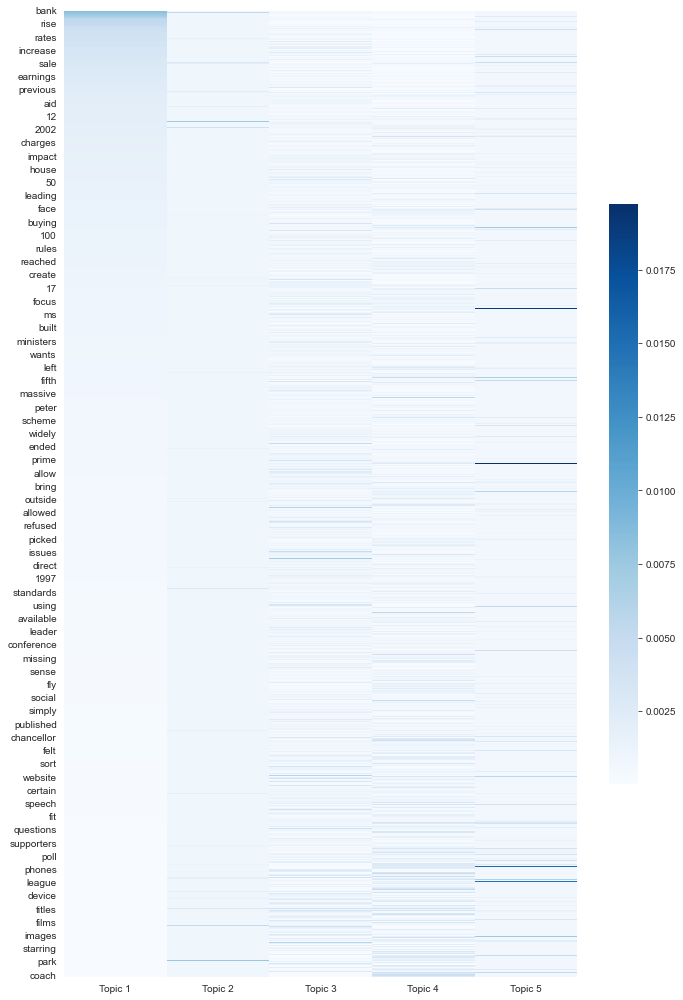

In [25]:
fig, ax = plt.subplots(figsize=(10, 14))
sns.heatmap(topics.sort_values(topic_labels, ascending=False),
            cmap='Blues', ax=ax, cbar_kws={'shrink': .6})
fig.tight_layout()

In [28]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,bank,chart,labour,film,open
1,growth,car,election,club,australian
2,sales,sales,blair,team,beat
3,economy,download,party,cup,round
4,shares,sold,technology,season,champion
5,oil,russian,mobile,awards,match
6,china,model,software,star,tournament
7,economic,music,brown,award,american
8,prices,unit,users,match,final
9,analysts,sale,computer,final,title


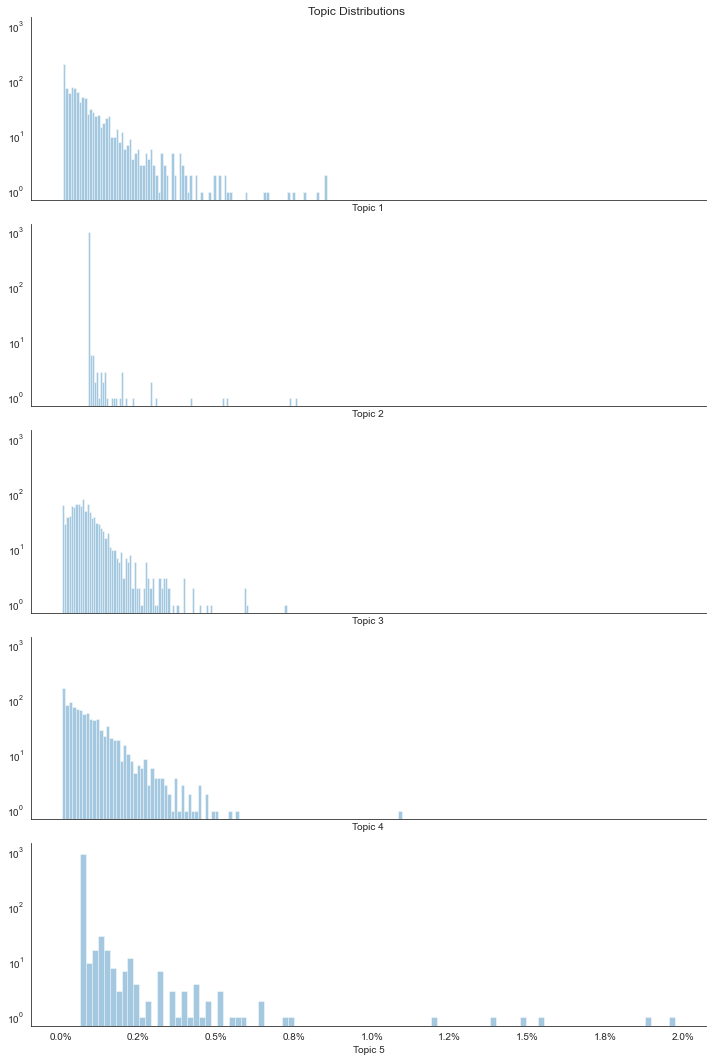

In [29]:
fig, axes = plt.subplots(nrows=5, sharey=True, sharex=True, figsize=(10, 15))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i], bins=100, kde=False, norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
sns.despine()
fig.tight_layout()

In [32]:
train_preds = lda_base.transform(train_dtm)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Sport,0.029767,0.029249,0.029737,0.881733,0.029514
Tech,0.030573,0.029992,0.878222,0.031170,0.030043
Politics,0.021062,0.020743,0.916190,0.021149,0.020856
Sport,0.041081,0.040570,0.041181,0.836496,0.040672
Tech,0.030325,0.029314,0.553308,0.357577,0.029476


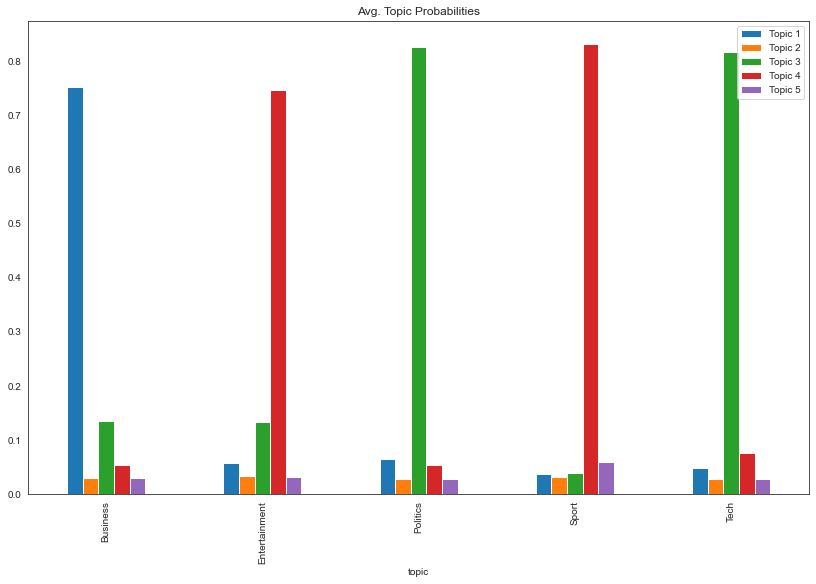

In [33]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

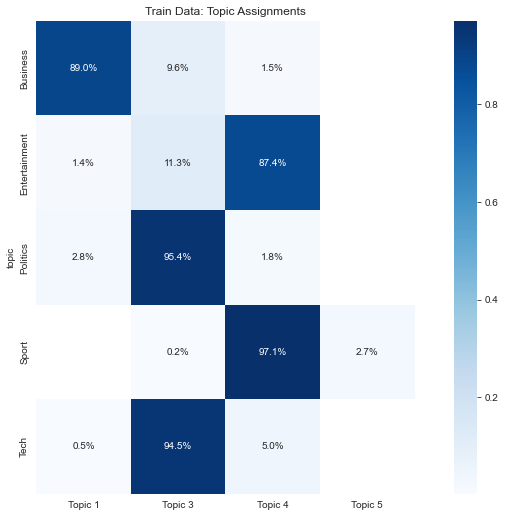

In [35]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');

In [36]:
test_preds = lda_base.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.topic)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Politics,0.025105,0.024739,0.899813,0.025466,0.024877
Sport,0.036074,0.035248,0.036907,0.856333,0.035437
Business,0.839866,0.031090,0.032236,0.063439,0.033368
Business,0.860775,0.030670,0.031567,0.046252,0.030736
Tech,0.149477,0.029566,0.760897,0.030358,0.029702


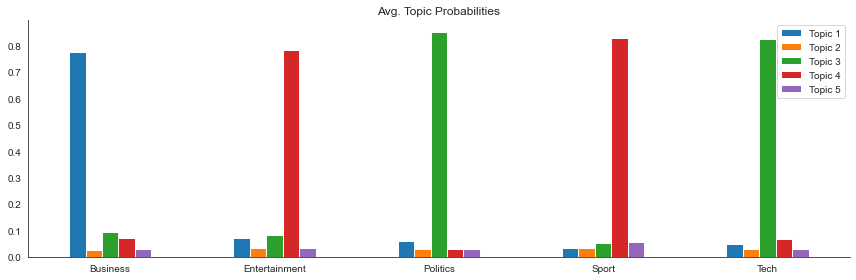

In [37]:
test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities',
                                                 figsize=(12, 4),
                                                 rot=0)
plt.xlabel('')
sns.despine()
plt.tight_layout()

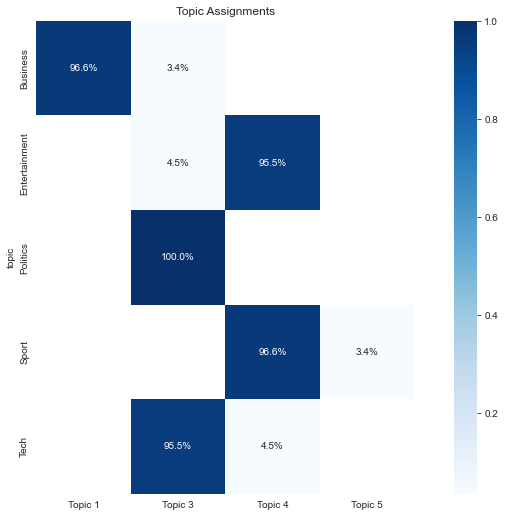

In [38]:
df = test_eval.groupby(level='topic').idxmax(axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True).unstack(-1), 
            annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments');

## Preplexity as a measure for optimality

In [39]:
lda_opt = LatentDirichletAllocation(n_components=5,
                                    n_jobs=-1,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=5,
                                    verbose=1,
                                    random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 1985.9009
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1900.6394
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 1887.4267
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1875.6741
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 1860.5418
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter:

LatentDirichletAllocation(evaluate_every=5, max_iter=500, n_components=5,
                          n_jobs=-1, random_state=42, verbose=1)

In [40]:
joblib.dump(lda_opt, model_path / 'lda_opt.pkl')


['results\\bbc\\lda_opt.pkl']

In [41]:
lda_opt = joblib.load(model_path / 'lda_opt.pkl')


In [43]:
train_opt_eval = pd.DataFrame(data=lda_opt.transform(train_dtm),
                              columns=topic_labels,
                              index=train_docs.topic)

test_opt_eval = pd.DataFrame(data=lda_opt.transform(test_dtm),
                             columns=topic_labels, 
                             index=test_docs.topic)

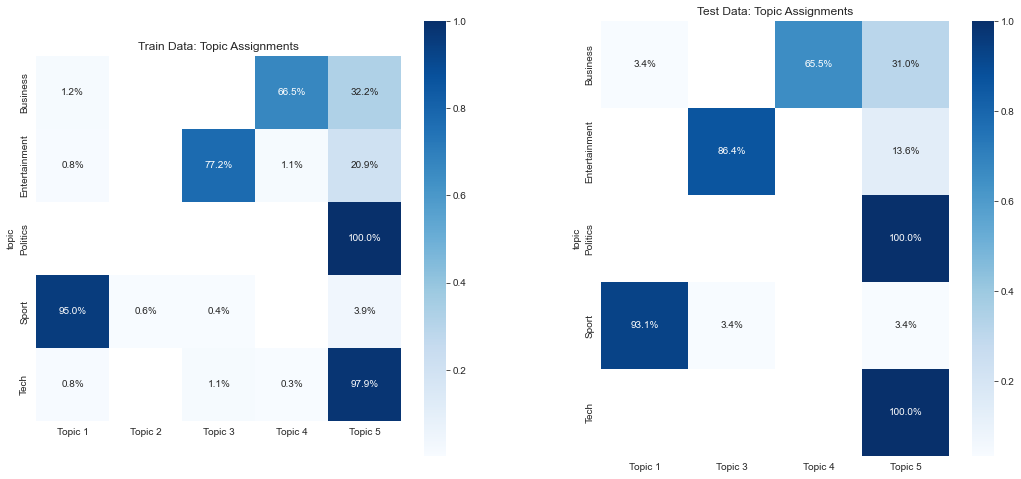

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
source = ['Train', 'Test']
for i, df in enumerate([train_opt_eval, test_opt_eval]):
    df = df.groupby(level='topic').idxmax(axis=1).reset_index(-1, drop=True)
    sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
                .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]))

In [45]:
test_assignments = test_docs.assign(predicted=test_opt_eval.idxmax(axis=1).values)
test_assignments.head()

,topic,heading,article,predicted
1006,Politics,Kilroy launches 'Veritas' party,Ex-BBC chat show host and East Midlands MEP R...,Topic 5
1358,Sport,Radcliffe eyes hard line on drugs,Paula Radcliffe has called for all athletes f...,Topic 1
71,Business,S Korean consumers spending again,South Korea looks set to sustain its revival ...,Topic 4
372,Business,Quiksilver moves for Rossignol,"Shares of Skis Rossignol, the world's largest...",Topic 4
2151,Tech,Britons fed up with net service,A survey conducted by PC Pro Magazine has rev...,Topic 5


In [47]:

misclassified = test_assignments[(test_assignments.topic == 'Entertainment') & (
    test_assignments.predicted == 'Topic 3')]
misclassified.heading

762     Scissor Sisters triumph at Brits
773     Grammys honour soul star Charles
839     Douglas set for Indian adventure
724    South Bank Awards honour hit soap
846     Career honour for actor DiCaprio
832      Vera Drake leads UK Oscar hopes
604    Aviator wins top Globes accolades
553      US actor Ossie Davis found dead
794    Rapper 50 Cent scores chart first
552     Stars pay tribute to actor Davis
544     Hundreds vie for best film Oscar
688    Housewives lift Channel 4 ratings
811    Actress Roberts takes spider role
599     Berlin cheers for anti-Nazi film
574    Animation charms Japan box office
751     TOTP turns to Elvis impersonator
610     Sundance to honour foreign films
602    Godzilla gets Hollywood fame star
777    Black Sabbath top rock album poll
Name: heading, dtype: object

In [48]:
misclassified.article.tolist()


[' US band Scissor Sisters led the winners at the UK music industry\'s Brit Awards, walking off with three prizes. The flamboyant act scored a hat-trick in the international categories, winning the best group, best album and best newcomer awards. Glasgow group Franz Ferdinand won two prizes, as did Keane and Joss Stone, who was voted best urban act by digital TV viewers. Robbie Williams\' Angels was named the best song of the past 25 years. Scissor Sisters frontwoman Ana Matronic collected the best international album prize from singer Siouxsie Sioux. She told the audience: "If you told us a year ago we would be getting these awards today we would have called you crazy. You guys made our dream come true."  The band - whose self-titled LP was 2004\'s biggest-selling album - thanked "all the members of the sisterhood", adding: "We wouldn\'t be here without you." The US band, who opened the show with Take Your Mama, won the best international act and newcomer awards, as well as best inter

## pyLDAvis

In [49]:
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=5,
                             stop_words='english',
                             max_features=2000)
dtm = vectorizer.fit_transform(docs.article)

In [50]:
lda_all = LatentDirichletAllocation(n_components=5,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=10,
                                    random_state=42,
                                    verbose=1)
lda_all.fit(dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1019.9467
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1006.8139
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 1003.1615
iteration:

LatentDirichletAllocation(evaluate_every=10, max_iter=500, n_components=5,
                          random_state=42, verbose=1)

In [51]:
joblib.dump(lda_all, model_path /'lda_all.pkl')


['results\\bbc\\lda_all.pkl']

In [52]:
lda_all = joblib.load(model_path / 'lda_all.pkl') 


In [53]:
prepare(lda_all, dtm, vectorizer)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.073450  0.078507       1        1  25.501837
3      0.095719 -0.098360       2        1  21.840844
0      0.141084  0.011426       3        1  20.954199
4     -0.142908  0.141046       4        1  18.692064
1     -0.167345 -0.132619       5        1  13.011057, topic_info=         Term         Freq        Total Category  logprob  loglift
1200       mr  2987.000000  2987.000000  Default  30.0000  30.0000
724      film   838.000000   838.000000  Default  29.0000  29.0000
230      best   960.000000   960.000000  Default  28.0000  28.0000
1022   labour   770.000000   770.000000  Default  27.0000  27.0000
780      game   855.000000   855.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1081   london   145.604869   454.658340   Topic5  -5.5414   0.9007
1816     time   158.747400  1303.506427   Topic5  -5.4550  -0.0661
1607   series   135.441328   252.071835   Topic5  -5.6138   1.4182
1977    world   147.425268  1173.233921   Topic5  -5.5290  -0.0348
1165  million   135.595694   574.095651   Topic5  -5.6126   0.5963

[353 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.270257      000
0         2  0.219976      000
0         3  0.382130      000
0         4  0.007542      000
0         5  0.121930      000
...     ...       ...      ...
1992      4  0.191599    years
1992      5  0.233952    years
1997      3  0.990918  yugansk
1998      3  0.996584    yukos
1999      4  0.987970  zealand

[672 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])